<!--NAVIGATION-->
< [深入：主成分分析](05.09-Principal-Component-Analysis.ipynb) | [目录](Index.ipynb) | [深入：k-均值聚类](05.11-K-Means.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.10-Manifold-Learning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In-Depth: Manifold Learning

# 深入：流形学习

> We have seen how principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points.
While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are *nonlinear* relationships within the data; we will see some examples of these below.

上一节已经介绍了主成分分析（PCA）用来进行降维，即减少数据集特征的数量却保留了数据点之间的关键关联。虽然PCA很灵活、快速和容易解释，它在数据之间存在*非线性*关系的时候表现不是特别好；我们会在下面的一些例子中看到。

> To address this deficiency, we can turn to a class of methods known as *manifold learning*—a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces.
When you think of a manifold, I'd suggest imagining a sheet of paper: this is a two-dimensional object that lives in our familiar three-dimensional world, and can be bent or rolled in that two dimensions.
In the parlance of manifold learning, we can think of this sheet as a two-dimensional manifold embedded in three-dimensional space.

要解决上面的问题，我们可以使用一类被称为*流形学习*的方法，这是一类无监督学习评估器试图使用低维度的流形来描述高纬度空间的数据集。当提到流形时，我们可以想象一张纸：这是一个二维的对象，处于我们熟悉的三维世界中，还能在这个基础上被弯曲或翻卷。如果类推到流形学习中，我们可以将这张纸看成是三维空间中的二维流形。

> Rotating, re-orienting, or stretching the piece of paper in three-dimensional space doesn't change the flat geometry of the paper: such operations are akin to linear embeddings.
If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear.
Manifold learning algorithms would seek to learn about the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.

在三维空间中旋转、重定位或者延展这张纸不会改变纸张的平面几何特性：这样的操作都可以归类为线性嵌入操作。如果你弯曲、卷曲或者翻卷纸张，它仍然是一个二维流形，但是这些操作在三维空间中不再是线性嵌入操作。流形学习算法会试图找到这张纸的二维本质，即使它卷曲延伸在一个三维空间中。

> Here we will demonstrate a number of manifold methods, going most deeply into a couple techniques: multidimensional scaling (MDS), locally linear embedding (LLE), and isometric mapping (IsoMap).

本节中我们会展示一些流形学习方法，底层主要依赖三个技巧：多维缩放（MDS）、本地线性嵌入（LLE）和等距映射（IsoMap）。

> We begin with the standard imports:

载入需要的包：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Manifold Learning: "HELLO"

## 流形学习的“HELLO”

> To make these concepts more clear, let's start by generating some two-dimensional data that we can use to define a manifold.
Here is a function that will create data in the shape of the word "HELLO":

为令这些概念更加清晰，让我们首先创建一些二维数据可以用来定义流形。下面是创建一个“HELLO”形状的数据的函数定义：

In [2]:
def make_hello(N=1000, rseed=42):
    # 创建一个“HELLO”形状的图像，保存为PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # 打开图像，在HELLO字体附近随机绘制一些图像点
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

> Let's call the function and visualize the resulting data:

然后调用函数展示结果图像：

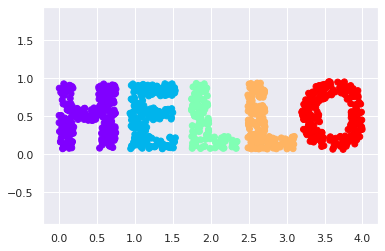

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

> The output is two dimensional, and consists of points drawn in the shape of the word, "HELLO".
This data form will help us to see visually what these algorithms are doing.

输出结果是二维的，包括着沿着HELLO形状绘制的点。这个数据会帮助我们可视化的展示算法的行为。

## Multidimensional Scaling (MDS)

## 多维缩放（MDS）

> Looking at data like this, we can see that the particular choice of *x* and *y* values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent.
For example, if we use a rotation matrix to rotate the data, the *x* and *y* values change, but the data is still fundamentally the same:

看到这样的数据，我们可以想象，图中这些特殊选择的*x*和*y*值并不是数据最基础的描述：我们可以缩放或者旋转数据，这个HELLO形状仍然会很明显。例如，如果我们如下旋转数据集：

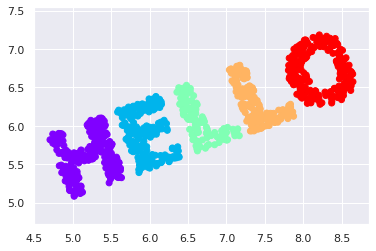

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

> This tells us that the *x* and *y* values are not necessarily fundamental to the relationships in the data.
What *is* fundamental, in this case, is the *distance* between each point and the other points in the dataset.
A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.
Let's use Scikit-Learn's efficient ``pairwise_distances`` function to do this for our original data:

上面的例子告诉我们数据集中的*x*和*y*值并不是数据关系中必不可少的基础成分。在这个情况下，最基础的是数据集每个点和其他点之间*距离*。使用距离矩阵来表示是一种通用的方法：对于$N$个点，我们构建一个$N \times N$数组，数组中的元素$(i, j)$指代的是点$i$和点$j$之间的距离。下面我们使用Scikit-Learn中高效的`pairwise_distance`函数来为我们的原始数据创建距离矩阵：

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

> As promised, for our *N*=1,000 points, we obtain a 1000×1000 matrix, which can be visualized as shown here:

意料之中，对于我们*N*=1000个点，我们获得了一个1000×1000的矩阵，我们可以如下可视化这个矩阵：

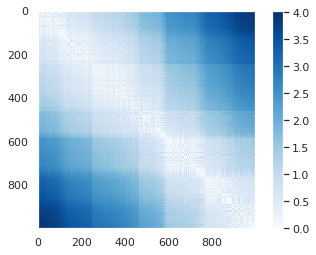

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

> If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:

如果我们采用同样的方法对旋转投射后的数据构建一个距离矩阵，我们就可以发现它们是相同的：

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

> This distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization of the matrix above is not entirely intuitive.
In the representation shown in this figure, we have lost any visible sign of the interesting structure in the data: the "HELLO" that we saw before.

虽然这个距离矩阵为我们提供了数据对于旋转和投射不敏感的证据，但是对矩阵的可视化结果却是完全不直观的。在距离矩阵的可视化图中，我们损失了任何数据关键结构中的可视标志：也就是前面我们能看到的“HELLO”。

> Further, while computing this distance matrix from the (x, y) coordinates is straightforward, transforming the distances back into *x* and *y* coordinates is rather difficult.
This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data.
Let's see how it works for our distance matrix, using the ``precomputed`` dissimilarity to specify that we are passing a distance matrix:

还有就是，虽然从(x, y)坐标中计算得到距离矩阵是很直接的，但是将距离矩阵转换回(x, y)坐标却是非常困难的。这正是多维缩放算法的目标：给定点之间的距离矩阵，将其还原成一个$D$维坐标的数据表示。在我们的距离矩阵上使用`precomputed`不相似度来指定我们传递的是距离矩阵：

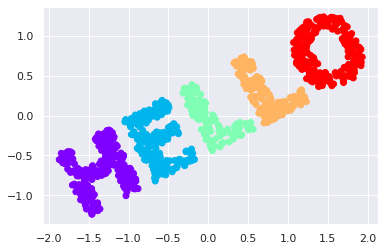

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

> The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using *only* the $N\times N$ distance matrix describing the relationship between the data points.

MDS算法还原了我们数据的一种可能的二维坐标表示，其中仅仅使用了描述数据点之间关系的$N \times N$的距离矩阵。

## MDS as Manifold Learning

## MDS进行流形学习

> The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in *any* dimension.
So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

当我们考虑到距离矩阵可以从*任何*维度的数据中计算得到时，上述特性变得更加明显。例如，我们可以将“HELLO”投射到3维中而不是上面的二维旋转，使用下面的函数（基本上就是前面的矩阵旋转函数的三维通用版本）即可实现：

In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

> Let's visualize these points to see what we're working with:

将这些三维中投射的点可视化出来：

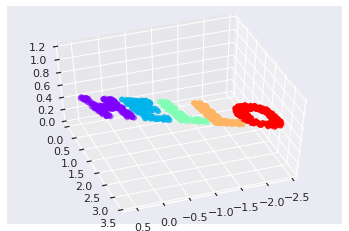

In [10]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

> We can now ask the ``MDS`` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix.
The result recovers a representation of the original data:

我们可以将这个三维数据作为输入代入`MDS`评估器，计算距离矩阵，然后求出该距离矩阵最优化的二维表示。结果还原了原始数据的最基础特征：

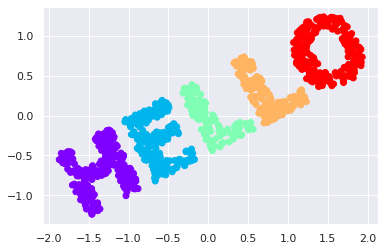

In [11]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

> This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data.
In the case of MDS, the quantity preserved is the distance between every pair of points.

这就是流形学习评估器的最基本目标：给定高维度的数据，它能找到一个低维度的数据表示，并且保留大部分数据之间的联系。在MDS算法中，被保留下来的数量是每两个点之间的距离。

## Nonlinear Embeddings: Where MDS Fails

## 非线性嵌入：MDS会失效

> Our discussion thus far has considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.
Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.
Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

目前为止我们讨论的都是*线性*嵌入，基本上就是包括将数据旋转、转换和缩放到高维空间。MDS会在非线性嵌入的情况下失效：这种情况下超越了上述简单的操作。考虑下面这种嵌入，函数会将输入扭曲成一个三维空间中的“S”形状：

In [12]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

This is again three-dimensional data, but we can see that the embedding is much more complicated:

结果还是三维数据，但是我们可以看到这个嵌入比前面复杂多了：

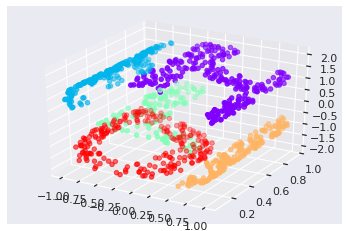

In [13]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

> The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

数据点之间的基本关系仍然保留下来了，但是这次数据被转换成了非线性形状：它们被封装成了一个“S”的形状。

> If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

如果我们在这之上尝试简单的MDS算法，它将无法对这种非线性嵌入进行解封装，也就是我们失去了这个嵌入流形的基础关系：

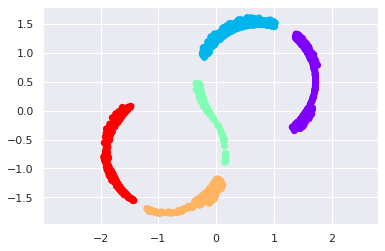

In [14]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

> The best two-dimensional *linear* embeding does not unwrap the S-curve, but instead throws out the original y-axis.

二维最好的“线性”嵌入无法将S曲线解封装，而是直接返回了原始数据的y轴。

## Nonlinear Manifolds: Locally Linear Embedding

## 非线性流形：本地线性嵌入

> How can we move forward here? Stepping back, we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding.
But what if we instead modified the algorithm such that it only preserves distances between nearby points?
The resulting embedding would be closer to what we want.

我们该如何进行下去呢？回想一下，我们发现问题的根源在于MDS保留了相隔很远的点之间的距离。如果我们修改一下算法，让它仅仅保留附近的点之间的距离呢？结果的嵌入方式会更加接近我们希望得到的。

> Visually, we can think of it as illustrated in this figure:

从下面的图像中我们可以看到两者之间的区别：

![(LLE vs MDS linkages)](figures/05.10-LLE-vs-MDS.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#LLE-vs-MDS-Linkages)

> Here each faint line represents a distance that should be preserved in the embedding.
On the left is a representation of the model used by MDS: it tries to preserve the distances between each pair of points in the dataset.
On the right is a representation of the model used by a manifold learning algorithm called locally linear embedding (LLE): rather than preserving *all* distances, it instead tries to preserve only the distances between *neighboring points*: in this case, the nearest 100 neighbors of each point.

上面每条淡色的线条代表着在嵌入算法中需要保留的距离。左图表示的MDS算法：它保留了数据集中每一对点之间的距离。右图展示的是被称为本地线性嵌入（LLE）的一种流形学习算法：与其保留*所有*距离，它仅仅保留了那些*邻近点*之间的距离：在这个例子中，每个点都有100个最邻近的点。

> Thinking about the left panel, we can see why MDS fails: there is no way to flatten this data while adequately preserving the length of every line drawn between the two points.
For the right panel, on the other hand, things look a bit more optimistic. We could imagine unrolling the data in a way that keeps the lengths of the lines approximately the same.
This is precisely what LLE does, through a global optimization of a cost function reflecting this logic.

再次考虑左图，我们可以发现MDS失效的原因：它无法将这些距离数据平铺出来，因为每两个点之间的距离都被保留了下来。对于右图来说，情况乐观得多，我们可以想象成沿着S形状将数据展开出来，因为不沿着这个形状的两点之间的距离并没有被保留下来。这就是LLE的原理，通过一个反映该逻辑的损失函数进行全局的优化。

> LLE comes in a number of flavors; here we will use the *modified LLE* algorithm to recover the embedded two-dimensional manifold.
In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion:

LLE有许多的方式；这里我们采用了改良LLE（*modified LLE*）算法来还原嵌入的二维流形。在通常情况下，改良LLE在还原良好定义流形的实践中要比其他算法的表现都要优异，造成的扭曲非常少：

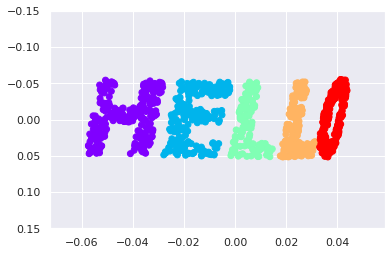

In [15]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

> The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!

结果和原始流形比较还是存在一些变形，但是它还是捕获了数据中的关键关系。

## Some Thoughts on Manifold Methods

## 关于流形方法的一些思考

> Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

虽然本节以及上面讲述很吸引人，但是实践中流形学习技巧却是非常挑剔的，导致它们很少在除了将高维度数据进行数值可视化领域外使用。

> The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

> - In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.
- In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.
- The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.
- In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.
- In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.
- In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the [megaman](https://github.com/mmp2/megaman) package for some more scalable implementations of manifold learning).

下面列出了一些流形学习的缺点，基本上都是与PCA比较的：

- 在流形学习中，没有好的框架来处理缺失数据。相反在PCA中，有很多直接和有效的方法实现缺失数据处理。
- 在流形学习中，数据中的噪声可能会导致流形“短路”从而剧烈的改变嵌入结果。相反，PCA可以在最重要成分之外很自然的过滤噪声。
- 流形嵌入结果通常高度依赖于临近点个数的选择，并且没有通用可证的数值方法来选择邻近点数量的最优解。相反，PCA不存在这样的选择。
- 在流形学习中，输出维度的全局最优解很难得到。相反，PCA通过可解释方差可以找到输出维度的全局最优解。
- 在流形学习中，嵌入维度的含义并不总是清晰的。PCA中的主成分有着非常明确的含义。
- 流形学习中流形算法的计算复杂度通常是O[N^2]或O[N^3]。而PCA存在随机方法，通常计算快许多（当然你也可以参看[megaman](https://github.com/mmp2/megaman)包，这里包含一些更具扩展性的流形学习的计算实现）。

> With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.

有了上表列出的这些缺点，流形学习对比PCA只有一个明显的优点，就是它能保留数据中的非线性关系；因此，作者建议对数据完成了PCA分析之后，再采用流形学习方法。

> Scikit-Learn implements several common variants of manifold learning beyond Isomap and LLE: the Scikit-Learn documentation has a [nice discussion and comparison of them](http://scikit-learn.org/stable/modules/manifold.html).
Based on my own experience, I would give the following recommendations:

> - For toy problems such as the S-curve we saw before, locally linear embedding (LLE) and its variants (especially *modified LLE*), perform very well. This is implemented in ``sklearn.manifold.LocallyLinearEmbedding``.
- For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings. This is implemented in ``sklearn.manifold.Isomap``
- For data that is highly clustered, *t-distributed stochastic neighbor embedding* (t-SNE) seems to work very well, though can be very slow compared to other methods. This is implemented in ``sklearn.manifold.TSNE``.

Scikit-Learn除了Isomap和LLE之外，还实现了一些常见的流形学习方法变体：Scikit-Learn文档中有一篇[很好的针对它们的讨论和比较文章](http://scikit-learn.org/stable/modules/manifold.html)。基于作者自身的经验，给出了下面的一些建议：

- 对于一些玩具问题，例如我们前面看到的S曲线，本地线性嵌入（LLE）和它的变体（特别是改良LLE）表现的很优秀。它们实现在`sklearn.manifold.LocallyLinearEmbedding`。
- 对于真实世界中的高维度数据，LLE经常产生很差的结果，而等距映射（IsoMap）通常会得到更加有意义的嵌入。它们实现在`sklearn.manifold.Isomap`。
- 对于高度聚集的数据，T-分布随机近邻嵌入（t-SNE）工作的较好，虽然相对其他方法来说它非常慢。它们实现在`sklearn.manifold.TSNE`。

> If you're interested in getting a feel for how these work, I'd suggest running each of the methods on the data in this section.

如果你对于这些算法的工作原理感兴趣，作者建议在本节的数据例子上运行每一个方法来查看结果。

## Example: Isomap on Faces

## 例子：人脸数据上使用Isomap

> One place manifold learning is often used is in understanding the relationship between high-dimensional data points.
A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

流形学习经常被用来理解高维度数据点之间的关系。图像是高维度数据的常见场景：例如，一组的1000像素点的图像，其中的每一张都可以被认为是1000维数据点的集合，每个像素的亮度定义了该维度的坐标值。

> Here let's apply Isomap on some faces data.
We will use the Labeled Faces in the Wild dataset, which we previously saw in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) and [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb).
Running this command will download the data and cache it in your home directory for later use:

下面我们将Isomap算法应用到一些人脸数据上。我们继续使用Wild数据集中的标签人脸数据，我们在前面的[深入：支持向量机](05.07-Support-Vector-Machines.ipynb) and [深入：主成分分析](05.09-Principal-Component-Analysis.ipynb)中都使用过它。使用下面的命令会下载数据并将其缓存在你的主目录中：

In [16]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

> We have 2,370 images, each with 2,914 pixels.
In other words, the images can be thought of as data points in a 2,914-dimensional space!

我们有2370张图像，每张都是2914个像素。换言之，每张图像都可以被认为是在2914维空间中的数据点的集合。

> Let's quickly visualize several of these images to see what we're working with:

我们展示部分图像，看看我们的数据集是怎样的：

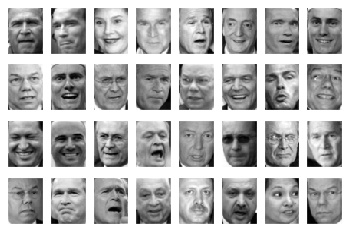

In [17]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

> We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images.
One useful way to start is to compute a PCA, and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

我们希望绘制这些2914维数据的低维度嵌入，从而获得这些图像之间的基本关系。从计算PCA开始是一个不错的办法，然后检查可解释方差的比率，能为我们提供描述数据所需的线性特征值数量的基本概念：

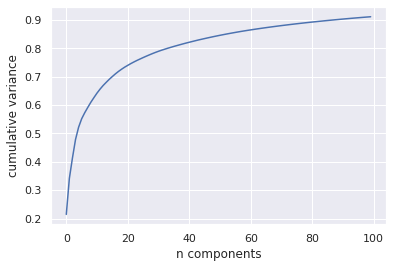

In [18]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

> We see that for this data, nearly 100 components are required to preserve 90% of the variance: this tells us that the data is intrinsically very high dimensional—it can't be described linearly with just a few components.

我们从上图可见，接近100个成分就能保留90%的差异：这告诉我们，这些数据本质上就是非常高维度的，它无法仅使用几个成分进行线性描述。

> When this is the case, nonlinear manifold embeddings like LLE and Isomap can be helpful.
We can compute an Isomap embedding on these faces using the same pattern shown before:

这种情况下，非线性流形嵌入如LLE和Isomap比较有帮助。我们可以使用Isomap嵌入来计算这些人脸数据的二维投射：

In [19]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

> The output is a two-dimensional projection of all the input images.
To get a better idea of what the projection tells us, let's define a function that will output image thumbnails at the locations of the projections:

输出结果是所有输入图像的二维投射。要获得这个二维投射的意义，我们定义一个函数，它会将相应的缩略图绘制在投射点的对应位置：

In [20]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # 如果两点距离太近，不显示
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Calling this function now, we see the result:

调用函数获得结果：

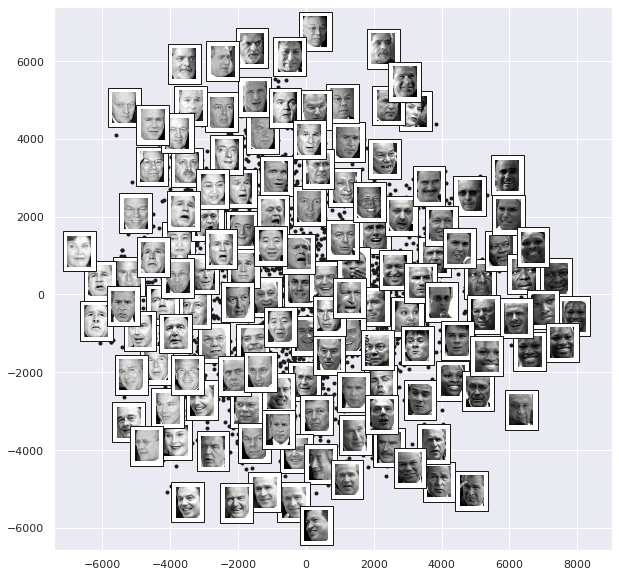

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

> The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top.
This gives us a nice visual indication of some of the fundamental features in our data.

这个结果很有趣：Isomap前两个维度看起来是在描述图像中的通用特征：从左到右是图像的亮度或暗度的变化，从上到下是图像中人脸方向的变化。这能为我们提供关于数据关键特征的很好的可视化指示。

> We could then go on to classify this data (perhaps using manifold features as inputs to the classification algorithm) as we did in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb).

然后我们可以继续对数据进行分类（使用流形特征作为分类算法的输入），正如我们在[深入：支持向量机](05.07-Support-Vector-Machines.ipynb)中做的那样。

## Example: Visualizing Structure in Digits

## 例子：手写数字的结构可视化

> As another example of using manifold learning for visualization, let's take a look at the MNIST handwritten digits set.
This data is similar to the digits we saw in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb), but with many more pixels per image.
It can be downloaded from http://mldata.org/ with the Scikit-Learn utility:

下面我们使用MNIST手写数字数据集来作为流形学习可视化数据的另外一个例子。这个数据集与[深入：决策树和随机森林](05.08-Random-Forests.ipynb)中的类似，但是每张图像有着更多的像素点。它可以使用Scikit-Learn工具从http://mldata.org/ 下载：

译者注：fetch_mldata已经无法从mldata.org中获得数据集，事实上mldata.org已经停止服务。同样使用fetch_openml替换也会发生错误，原因猜测是无法描述吧。你可以在[MNIST MAT文件](https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat)下载本节所需的数据集文件，然后将它放置在$HOME/scikit_learn_data/mldata目录中，如果目录不存在就创建它：

```bash
mkdir -p $HOME/scikit_learn_data/mldata
```

然后就不需要从网络中下载了。

In [22]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

/home/wangy/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/home/wangy/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


(70000, 784)

> This consists of 70,000 images, each with 784 pixels (i.e. the images are 28×28).
As before, we can take a look at the first few images:

我们看到这个数据集包含70000张图，每张图有784个像素点（即28×28规格）。惯例上我们先看看数据集前面的部分图像：

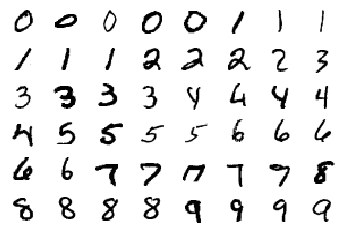

In [23]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

> This gives us an idea of the variety of handwriting styles in the dataset.

上图可以让我们大概看到手写数字的一些不同的风格。

> Let's compute a manifold learning projection across the data.
For speed here, we'll only use 1/30 of the data, which is about ~2000 points
(because of the relatively poor scaling of manifold learning, I find that a few thousand samples is a good number to start with for relatively quick exploration before moving to a full calculation):

下面我们来计算这个数据集的流形学习投射。因为速度原因，这里仅使用了数据集的1/30，也就是大约2000个点（因为流形学习相对较高的计算复杂度，作者认为几千个样本是一个比较合适的数据集大小，如果需要深入，再进行全样本集的计算）：

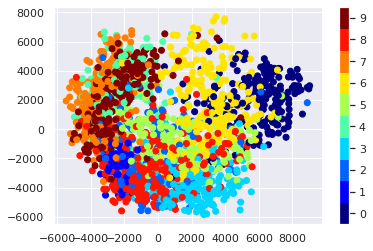

In [24]:
# 仅适用1/30的数据，全数据集将花费很长的时间
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

> The resulting scatter plot shows some of the relationships between the data points, but is a bit crowded.
We can gain more insight by looking at just a single number at a time:

结果中的散点图展示了数据点之间的一些关系，但是看起来显得有点拥挤。我们可以通过一次只看一个数字来获得更加清晰的展示效果：

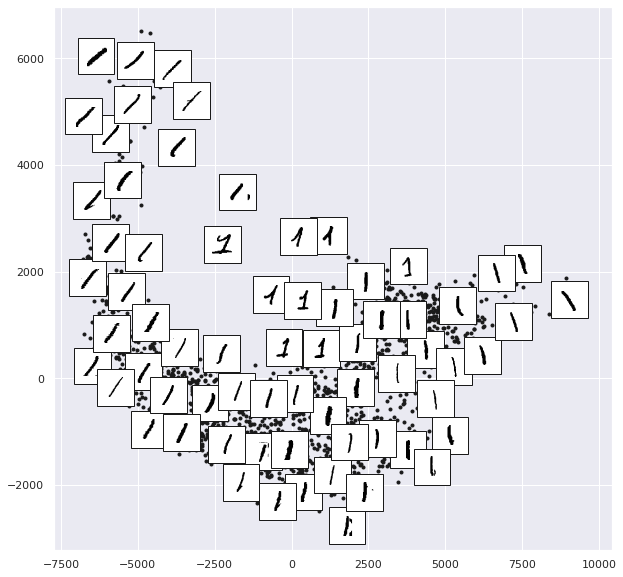

In [25]:
from sklearn.manifold import Isomap

# 选择1/4的数字1进行展示分析
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

> The result gives you an idea of the variety of forms that the number "1" can take within the dataset.
The data lies along a broad curve in the projected space, which appears to trace the orientation of the digit.
As you move up the plot, you find ones that have hats and/or bases, though these are very sparse within the dataset.
The projection lets us identify outliers that have data issues: for example, pieces of the neighboring digits that snuck into the extracted images.

上面的结果展示了不同风格书写的数字一在散点图中的分布情况。这些数据点分布在一个宽的弧形区域中，观察可知沿着弧形变化的是数字1的书写方向。图中中上部的数字1都戴着帽子和/或划了底座，但是它们通常离散于弧形区域之外。这个投射情况也能让我们发现一些数据本身的缺陷问题：例如，邻近的数字部分被划到了提取出来的图像当中。

> Now, this in itself may not be useful for the task of classifying digits, but it does help us get an understanding of the data, and may give us ideas about how to move forward, such as how we might want to preprocess the data before building a classification pipeline.

因此，这不是我们用来作为数字分类的好工具，但是它能帮助我们理解数据集本身，还可以为我们提供一些好的想法，例如在我们创建分类器处理之前可以对数据进行预处理。

<!--NAVIGATION-->
< [深入：主成分分析](05.09-Principal-Component-Analysis.ipynb) | [目录](Index.ipynb) | [深入：k-均值聚类](05.11-K-Means.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.10-Manifold-Learning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
